## Описание задачи

Сердечно-сосудистые заболевания (ССЗ) являются основной причиной смерти во всем мире, унося, по оценкам, 17,9 миллиона жизней каждый год, что составляет 31% всех смертей в мире. Четыре из пяти случаев смерти от ССЗ обусловлены сердечными приступами и инсультами, и одна треть этих смертей происходит преждевременно у людей моложе 70 лет. Сердечная недостаточность - это распространенное событие, вызванное ССЗ, и этот набор данных содержит 11 признаков, которые можно использовать для прогнозирования возможного сердечного заболевания.

Люди с сердечно-сосудистыми заболеваниями или высоким сердечно-сосудистым риском (из-за наличия одного или нескольких факторов риска, таких как гипертония, диабет, гиперлипидемия или уже установленное заболевание) нуждаются в ранней диагностике и лечении, при котором модель машинного обучения может быть очень полезной.

url: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

### 📊 Описание признаков для диагностики сердечных заболеваний

| Признак | Описание | Возможные значения | Тип данных |
|---------|----------|-------------------|------------|
| <b>Age</b> | Возраст пациента | Числовое значение [лет] | Число |
| <b>Sex</b> | Пол пациента | <b>M</b>: Мужской, <b>F</b>: Женский | Категориальный |
| <b>ChestPainType</b> | Тип боли в груди | <b>TA</b>: Типичная стенокардия<br><b>ATA</b>: Атипичная стенокардия<br><b>NAP</b>: Неангинальная боль<br><b>ASY</b>: Бессимптомно | Категориальный |
| <b>RestingBP</b> | Артериальное давление в покое | Числовое значение [мм рт.ст.] | Число |
| <b>Cholesterol</b> | Уровень холестерина в сыворотке | Числовое значение [мм/дл] | Число |
| <b>FastingBS</b> | Уровень сахара натощак | <b>1</b>: Если > 120 мг/дл<br><b>0</b>: В противном случае | Бинарный |
| <b>RestingECG</b> | Результаты ЭКГ в покое | <b>Normal</b>: Нормально<br><b>ST</b>: Аномалии волны ST-T<br><b>LVH</b>: Гипертрофия левого желудочка | Категориальный |
| <b>MaxHR</b> | Максимальная частота сердечных сокращений | Числовое значение [60-202] | Число |
| <b>ExerciseAngina</b> | Стенокардия при физической нагрузке | <b>Y</b>: Да<br><b>N</b>: Нет | Бинарный |
| <b>Oldpeak</b> | Депрессия сегмента ST | Числовое значение | Число |
| <b>ST_Slope</b> | Наклон сегмента ST | <b>Up</b>: Восходящий<br><b>Flat</b>: Плоский<br><b>Down</b>: Нисходящий | Категориальный |
| <b>HeartDisease</b> | Класс заболевания | <b>1</b>: Сердечное заболевание<br><b>0</b>: Норма<br>Целевой признак| Бинарный |

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import phik
import seaborn as sns
import warnings

from catboost import CatBoostClassifier
from optuna import create_study, Trial
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
from optuna.storages import InMemoryStorage

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
    StratifiedKFold
)
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor

/home/sasha/Documents/vscode/legacy/ds/.dsvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 666
SCORING = 'f1'
N_TRIALS = 50

## Загрузка и первичный анализ данных

In [4]:
try:
    data = pd.read_csv('datasets/heart.csv')
except Exception as e:
    print(f"pd.read_csv failed: {e}")

data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


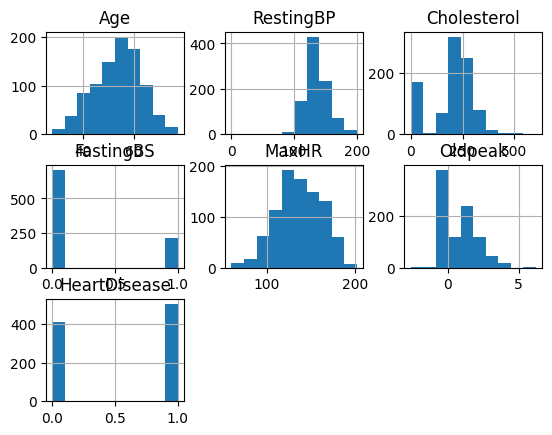

In [5]:
data.hist();

In [6]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Всего 918 обьектов, пропусков нет, 12 колонок.

## Предобработка

Создадим список категориальных переменных

In [7]:
categorial_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] 	 	  
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'FastingBS']

### обработка дубликатов

In [8]:
data.duplicated().sum()

0

дубликаты отстутствуют

## EDA

### Баланс классов

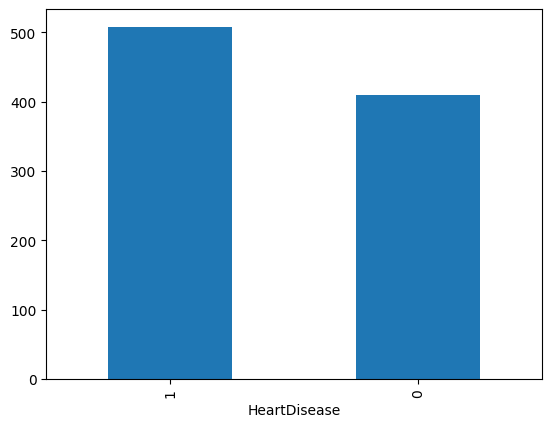

In [9]:
data['HeartDisease'].value_counts().plot(kind='bar');

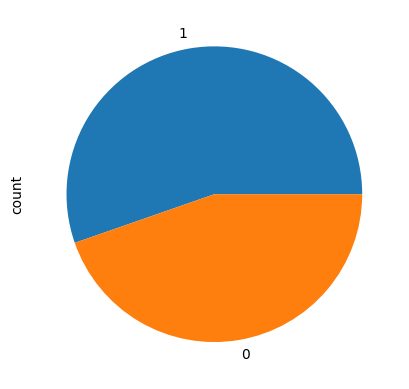

In [10]:
data['HeartDisease'].value_counts().plot(kind='pie');

присутствует диcбаланс классов

### Матрица кореляций

<Axes: >

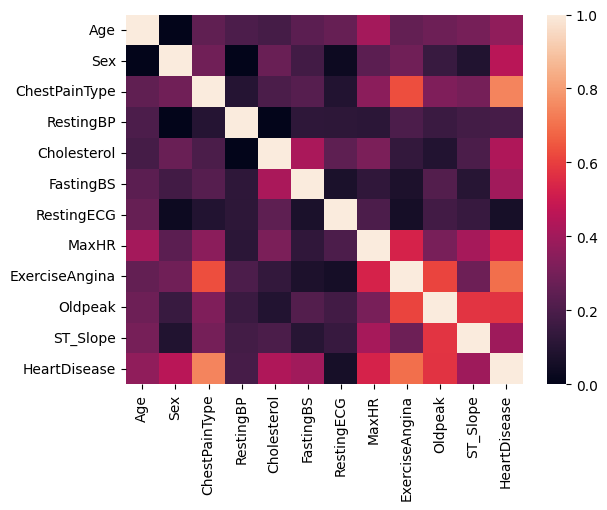

In [11]:
sns.heatmap(phik.phik_matrix(data, interval_cols=numerical_features))

Видим что много признаков скорелированы с целевым. Присутствует мультиколинеарность.

Расчитаем vif

In [12]:
def interpret_vif(vif):
    if vif == 1:
        return "No correlation; ideal situation."
    elif 1 < vif < 5:
        return "Moderate correlation; generally acceptable."
    elif vif >= 5 and vif < 10:
        return "High correlation; may be problematic."
    elif vif >= 10:
        return "Serious multicollinearity; further investigation needed."
    else:
        return "Invalid VIF value."


def calculate_vif(X):
    """
    Calculate Variance Inflation Factor for numeric and categorical features
    
    Parameters:
    X (DataFrame): Input features (independent variables)
    
    Returns:
    DataFrame: VIF values for each feature
    """
    # Create a copy of the dataframe
    X_processed = X.copy()
    
    # Handle categorical variables
    categorical_columns = X_processed.select_dtypes(include=['object', 'category']).columns
    
    # One-hot encode or label encode categorical variables
    for col in categorical_columns:
        # Option 1: Label Encoding (for ordinal or binary categories)
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col].astype(str))
    
    # Select only numeric columns
    numeric_columns = X_processed.select_dtypes(include=['int64', 'float64']).columns
    
    # Standardize the numeric features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_processed[numeric_columns])
    
    # Calculate VIF for each numeric feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_columns

    vifs = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
    vif_data["VIF"] = vifs
    vif_data['Interpretation'] = [interpret_vif(vif) for vif in vifs]
    
    return vif_data


In [13]:
calculate_vif(data)

,Feature,VIF,Interpretation
0,Age,1.340407,Moderate correlation; generally acceptable.
1,Sex,1.138159,Moderate correlation; generally acceptable.
2,ChestPainType,1.264834,Moderate correlation; generally acceptable.
3,RestingBP,1.116664,Moderate correlation; generally acceptable.
4,Cholesterol,1.241641,Moderate correlation; generally acceptable.
5,FastingBS,1.168605,Moderate correlation; generally acceptable.
6,RestingECG,1.080543,Moderate correlation; generally acceptable.
7,MaxHR,1.523811,Moderate correlation; generally acceptable.
8,ExerciseAngina,1.600811,Moderate correlation; generally acceptable.
9,Oldpeak,1.528789,Moderate correlation; generally acceptable.


Удаление признаков не требуется

## Dataset split

отделим целевой признак

In [14]:
target = data.pop('HeartDisease')

разделим датасет на тестовый и тренировочный

In [15]:
x_train, x_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

## Model selection

In [16]:
def make_OHE_preprocessor():
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorial_features),  # categorial features
        ],
        remainder='passthrough'
    )
    return preprocessor

def make_ordinal_preprocessor():
    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000), categorial_features),  # categorial features
        ],
        remainder='passthrough'
    )
    return preprocessor

In [17]:
results = {}
best_params = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
class_balance = None

In [18]:
preprocessor = make_OHE_preprocessor()

model = LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE, max_iter=10000)
model = Pipeline([('preprocessing', preprocessor),
                ('model', model)])

result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

result = result.mean()

results['LogisticRegression'] = result
best_params['LogisticRegression'] = None

result

0.8653063875655842

In [19]:
def objective(trial: Trial):
    max_depth = trial.suggest_int('max_depth', 2, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'] )

    preprocessor = make_ordinal_preprocessor()

    model = DecisionTreeClassifier(max_depth=max_depth,
                                   criterion=criterion,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=RANDOM_STATE)

    model = Pipeline([('preprocessing', preprocessor),
                    ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)

result = study.best_value

results['OrdinalDecisionTreeClassifier'] = result
best_params['OrdinalDecisionTreeClassifier'] = study.best_params

result

[I 2025-10-02 00:13:42,127] A new study created in memory with name: no-name-a314a126-3204-4e56-b116-347f7a357966
[I 2025-10-02 00:13:42,171] Trial 0 finished with value: 0.8226190827756421 and parameters: {'max_depth': 9, 'min_samples_split': 85, 'min_samples_leaf': 68, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8226190827756421.
[I 2025-10-02 00:13:42,218] Trial 1 finished with value: 0.8252558109907527 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.8252558109907527.
[I 2025-10-02 00:13:42,267] Trial 2 finished with value: 0.8084202263294946 and parameters: {'max_depth': 4, 'min_samples_split': 71, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.8252558109907527.
[I 2025-10-02 00:13:42,309] Trial 3 finished with value: 0.8155158438549861 and parameters: {'max_depth': 3, 'min_samples_split': 26, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 1 w

0.8454961299530384

In [20]:
def objective(trial: Trial):
    max_depth = trial.suggest_int('max_depth', 2, 12)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 100)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'] )

    preprocessor = make_OHE_preprocessor()

    model = DecisionTreeClassifier(max_depth=max_depth,
                                   criterion=criterion,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=RANDOM_STATE)

    model = Pipeline([('preprocessing', preprocessor),
                    ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)


result = study.best_value

results['OHEDecisionTreeClassifier'] = result
best_params['OHEDecisionTreeClassifier'] = study.best_params

result

[I 2025-10-02 00:13:44,750] A new study created in memory with name: no-name-321d3b2f-3ad4-4431-9c4b-8a786a9e262f
[I 2025-10-02 00:13:44,793] Trial 0 finished with value: 0.8218998699759592 and parameters: {'max_depth': 9, 'min_samples_split': 85, 'min_samples_leaf': 68, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8218998699759592.
[I 2025-10-02 00:13:44,836] Trial 1 finished with value: 0.8336437133079372 and parameters: {'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'log_loss'}. Best is trial 1 with value: 0.8336437133079372.
[I 2025-10-02 00:13:44,879] Trial 2 finished with value: 0.8201385015802194 and parameters: {'max_depth': 4, 'min_samples_split': 71, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 1 with value: 0.8336437133079372.
[I 2025-10-02 00:13:44,919] Trial 3 finished with value: 0.8388891103314222 and parameters: {'max_depth': 3, 'min_samples_split': 26, 'min_samples_leaf': 3, 'criterion': 'gini'}. Best is trial 3 w

0.8473809091231403

In [21]:
def objective(trial: Trial):
    C = trial.suggest_float('C', 0.00001, 1000)
    gamma = trial.suggest_float('gamma', 0.0001, 1)

    preprocessor = make_OHE_preprocessor()

    model = SVC(C=C, gamma=gamma, class_weight="balanced")

    model = Pipeline([('preprocessing', preprocessor),
                    ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)


result = study.best_value

results['SVC'] = result
best_params['SVC'] = study.best_params

result

[I 2025-10-02 00:13:47,471] A new study created in memory with name: no-name-0047142e-bcc7-499d-943a-3a440ad30097
[I 2025-10-02 00:13:47,652] Trial 0 finished with value: 0.7135305368050485 and parameters: {'C': 700.4371248534635, 'gamma': 0.8442022241861495}. Best is trial 0 with value: 0.7135305368050485.
[I 2025-10-02 00:13:47,832] Trial 1 finished with value: 0.7147881055055609 and parameters: {'C': 676.5143391724821, 'gamma': 0.72788527144235}. Best is trial 1 with value: 0.7147881055055609.
[I 2025-10-02 00:13:47,959] Trial 2 finished with value: 0.6957029270349617 and parameters: {'C': 951.4579579317598, 'gamma': 0.012801926715064155}. Best is trial 1 with value: 0.7147881055055609.
[I 2025-10-02 00:13:48,118] Trial 3 finished with value: 0.7008397479910099 and parameters: {'C': 413.58770465064646, 'gamma': 0.04890791252062004}. Best is trial 1 with value: 0.7147881055055609.
[I 2025-10-02 00:13:48,320] Trial 4 finished with value: 0.7147881055055609 and parameters: {'C': 99.928

0.7147881055055609

In [22]:
def objective(trial: Trial):
    max_depth = trial.suggest_int('max_depth', 2, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.000001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)

    preprocessor = make_ordinal_preprocessor()

    model = CatBoostClassifier(random_state=RANDOM_STATE,
                               n_estimators=n_estimators,
                               learning_rate=learning_rate,
                               max_depth=max_depth,
                               auto_class_weights="Balanced",
                               verbose=False)

    model = Pipeline([('preprocessing', preprocessor),
                    ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)


result = study.best_value

results['OrdinalCatBoostClassifier'] = result
best_params['OrdinalCatBoostClassifier'] = study.best_params

result

[I 2025-10-02 00:13:56,624] A new study created in memory with name: no-name-85e59848-f9be-41d6-b282-3b245051f3b6
[I 2025-10-02 00:14:03,558] Trial 0 finished with value: 0.8580145068828147 and parameters: {'max_depth': 9, 'learning_rate': 0.8441867986637916, 'n_estimators': 680}. Best is trial 0 with value: 0.8580145068828147.
[I 2025-10-02 00:14:03,993] Trial 1 finished with value: 0.8519800133990891 and parameters: {'max_depth': 10, 'learning_rate': 0.9514580059883819, 'n_estimators': 22}. Best is trial 0 with value: 0.8580145068828147.
[I 2025-10-02 00:14:04,370] Trial 2 finished with value: 0.8764114413244813 and parameters: {'max_depth': 6, 'learning_rate': 0.04881374498720623, 'n_estimators': 109}. Best is trial 2 with value: 0.8764114413244813.
[I 2025-10-02 00:14:07,820] Trial 3 finished with value: 0.8650629678119227 and parameters: {'max_depth': 7, 'learning_rate': 0.20024833908693815, 'n_estimators': 747}. Best is trial 2 with value: 0.8764114413244813.
[I 2025-10-02 00:14:

0.8821532044328281

In [23]:
def objective(trial: Trial):
    max_depth = trial.suggest_int('max_depth', 2, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.000001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)

    preprocessor = make_OHE_preprocessor()

    model = CatBoostClassifier(random_state=RANDOM_STATE,
                               n_estimators=n_estimators,
                               learning_rate=learning_rate,
                               max_depth=max_depth,
                               auto_class_weights="Balanced",
                               verbose=False)

    model = Pipeline([('preprocessing', preprocessor),
                    ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)


result = study.best_value

results['OHECatBoostClassifier'] = result
best_params['OHECatBoostClassifier'] = study.best_params

result

[I 2025-10-02 00:16:47,460] A new study created in memory with name: no-name-014075aa-1f03-4d9c-bde1-34bc63aa0452
[I 2025-10-02 00:17:00,703] Trial 0 finished with value: 0.8578239862910509 and parameters: {'max_depth': 9, 'learning_rate': 0.8441867986637916, 'n_estimators': 680}. Best is trial 0 with value: 0.8578239862910509.
[I 2025-10-02 00:17:01,542] Trial 1 finished with value: 0.8493017390324175 and parameters: {'max_depth': 10, 'learning_rate': 0.9514580059883819, 'n_estimators': 22}. Best is trial 0 with value: 0.8578239862910509.
[I 2025-10-02 00:17:02,064] Trial 2 finished with value: 0.8836159619141766 and parameters: {'max_depth': 6, 'learning_rate': 0.04881374498720623, 'n_estimators': 109}. Best is trial 2 with value: 0.8836159619141766.
[I 2025-10-02 00:17:07,366] Trial 3 finished with value: 0.8727813115038117 and parameters: {'max_depth': 7, 'learning_rate': 0.20024833908693815, 'n_estimators': 747}. Best is trial 2 with value: 0.8836159619141766.
[I 2025-10-02 00:17:

0.8860289555641986

In [24]:
def objective(trial: Trial):

    max_depth = trial.suggest_int('max_depth', 2, 12)
    learning_rate = trial.suggest_float('learning_rate', 0.000001, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)


    # preprocessor = ColumnTransformer(
    #     transformers=[
    #         ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorial_features),  # categorial features
    #         ],
    #         remainder='passthrough'
    #     )

    model = CatBoostClassifier(random_state=RANDOM_STATE,
                               cat_features=categorial_features,
                               n_estimators=n_estimators,
                               learning_rate=learning_rate,
                               max_depth=max_depth,
                               auto_class_weights="Balanced",
                               verbose=False)

    # model = Pipeline([('preprocessing', preprocessor),
    #                 ('model', model)])
    
    result = cross_val_score(model, x_train, y_train, cv=skf, scoring=SCORING)

    return result.mean()


sampler = TPESampler(seed=RANDOM_STATE)

storage = InMemoryStorage()

pruner = MedianPruner()

study = create_study(sampler=sampler,
                     storage=storage,
                     pruner=pruner,
                     directions=['maximize'])

study.optimize(objective, n_trials=N_TRIALS)


result = study.best_value

results['CatBoostClassifier'] = result
best_params['CatBoostClassifier'] = study.best_params

result

[I 2025-10-02 00:21:26,320] A new study created in memory with name: no-name-502e5a30-1899-47bb-8404-237e0d548c43
[I 2025-10-02 00:21:39,864] Trial 0 finished with value: 0.8562508151836244 and parameters: {'max_depth': 9, 'learning_rate': 0.8441867986637916, 'n_estimators': 680}. Best is trial 0 with value: 0.8562508151836244.
[I 2025-10-02 00:21:40,273] Trial 1 finished with value: 0.8682671696624821 and parameters: {'max_depth': 10, 'learning_rate': 0.9514580059883819, 'n_estimators': 22}. Best is trial 1 with value: 0.8682671696624821.
[I 2025-10-02 00:21:40,784] Trial 2 finished with value: 0.8702934156146588 and parameters: {'max_depth': 6, 'learning_rate': 0.04881374498720623, 'n_estimators': 109}. Best is trial 2 with value: 0.8702934156146588.
[I 2025-10-02 00:21:47,761] Trial 3 finished with value: 0.8772349087166085 and parameters: {'max_depth': 7, 'learning_rate': 0.20024833908693815, 'n_estimators': 747}. Best is trial 3 with value: 0.8772349087166085.
[I 2025-10-02 00:21:

0.8802443761088291

In [25]:
df = pd.DataFrame([results]).T
df.columns = [str(SCORING)]
df

,f1
LogisticRegression,0.865306
OrdinalDecisionTreeClassifier,0.845496
OHEDecisionTreeClassifier,0.847381
SVC,0.714788
OrdinalCatBoostClassifier,0.882153
OHECatBoostClassifier,0.886029
CatBoostClassifier,0.880244


In [26]:
def select_best_model(results: dict[str, float]) -> str:
    best_value = 0
    best_model = None
    for key in results.keys():
        if results[key] > best_value:
            best_model = key
            best_value = results[key]
    
    return best_model

In [27]:
best_model = select_best_model(results)
print('лучшая модель:',best_model)
print('лучший результат:', SCORING, round(results[best_model], 4))
print('параметры:', best_params[best_model])

лучшая модель: OHECatBoostClassifier
лучший результат: f1 0.886
параметры: {'max_depth': 3, 'learning_rate': 0.08475812022865768, 'n_estimators': 89}


## Testing

In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorial_features),  # categorial features
        ],
        remainder='passthrough'
    )


model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, **best_params[best_model])

model = Pipeline([('preprocessing', preprocessor),
                ('model', model)])

model.fit(x_train, y_train);

In [29]:
predictions = model.predict(x_test)

In [30]:
print('accuracy_score:',
      round(accuracy_score(y_test,predictions),
            4))

accuracy_score: 0.8967


In [31]:
print('f1_score:',
      round(f1_score(y_test, predictions),
            4))

f1_score: 0.9064


In [32]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88        82
           1       0.91      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



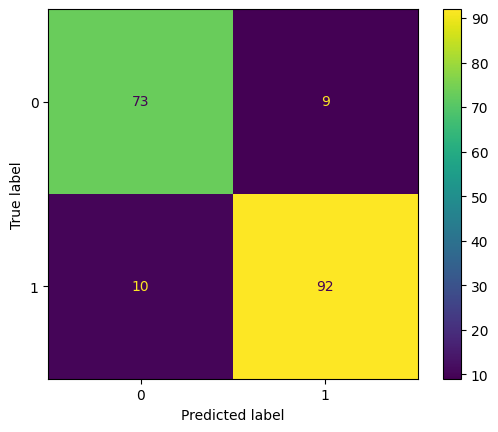

In [33]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))
cm.plot();

Модель показывает очень хорошие результаты, о чем свидетельствует высокая общая точность, высокий precission и recall. Модель имеет отличный f1 score.

## Feature importance

In [34]:
def remove_prefixes(columns):
    """
    Remove 'cat__' and 'remainder__' prefixes using regex.
    """
    columns = list(columns)

    pattern = r'^(cat__|remainder__)'
    return [re.sub(pattern, '', col) for col in columns]

In [35]:
columns = remove_prefixes(preprocessor.get_feature_names_out())

In [36]:
thrd = []

for e in columns:
    for ee in x_test.columns:
        if ee in e:
            thrd.append(ee)

ffth = []
for item in thrd:
    if item not in ffth:
        ffth.append(item)
ffth

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'Age',
 'RestingBP',
 'Cholesterol',
 'FastingBS',
 'MaxHR',
 'Oldpeak']

### permutation importance

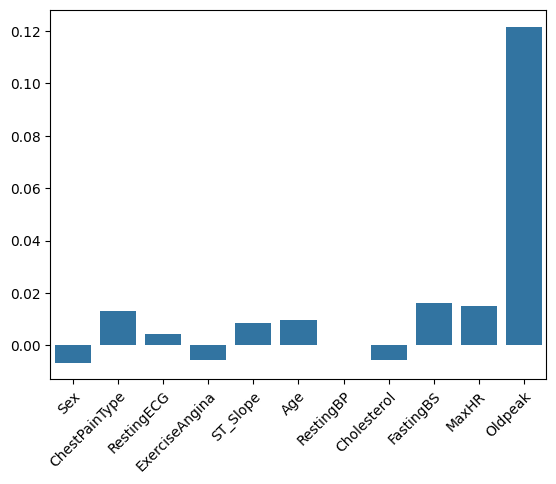

In [37]:
sns.barplot(x=ffth,
            y=permutation_importance(model, x_test, y_test)['importances_mean'],
            )

plt.xticks(
    rotation=45,  # Angle of rotation
    ha='right',   # Horizontal alignment
    rotation_mode='anchor'  # Helps with precise positioning
);

Самый важный предиктор с отрывом Oldpeak. Oldpeak – измерение отклонения (подъёма или понижения) сегмента ST на электрокардиограмме (ЭКГ) относительно изолинии. Вычисляется как разница между уровнем изоэлектрической линии и самым низким (или самым высоким) пунктом ST‑сегмента; обычно выражается в миллиметрах (мм) или милливольтах (мВ). Значения > 0,5 мм часто рассматриваются как показатель стенокардиальной ишемии.